# 06. PyTorch Transfer Learning
Using Pretrained Models
* Pretrained model = Foundation model

In [53]:
import torchvision
import torch
print(torchvision.__version__)
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

0.18.1+cu121
2.3.1+cu121


'cuda'

Let's import the code we've written in previous section.

In [54]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

## 1. Get data
We need our pizza, steak, sushi data to build a transfer learning model on

In [55]:
%%writefile going_modular/going_modular/download_data.py
import os
import zipfile
from pathlib import Path
import requests
data_path = Path("data/")
def download_data(data_name:str,
                  data_path:Path,
                  zip_name:str):
    """
    Download pizza, steak, sushi data and unzip to data_path / unzip_dir
    """
    image_path = data_path / data_name

# If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"{image_path} directory exists.")
    else:
        print(f"Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        with open(data_path / zip_name, "wb") as f:
            request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
            print("Downloading pizza, steak, sushi data...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / zip_name, "r") as zip_ref:
            print("Unzipping pizza, steak, sushi data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        os.remove(data_path / "pizza_steak_sushi.zip")

Overwriting going_modular/going_modular/download_data.py


In [56]:
from going_modular.going_modular.download_data import download_data
from pathlib import Path
download_data(data_name = "pizza_steak_sushi", data_path = Path("data/"), zip_name = "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [57]:
train_dir = Path("data/pizza_steak_sushi/train")
test_dir = Path("data/pizza_steak_sushi/test")

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` Contains pre-trained models (models ready for transfer learning inside torchvision)

In [58]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
manual_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # Resize image to (224, 224)
    transforms.ToTensor(), # get images into range [0, 1]
    normalize # Make sure our images have the same distribution as ImageNet
])

In [59]:
from torchvision import transforms
from torch.utils.data import DataLoader
import os
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
from going_modular.going_modular import data_setup
train_dataloader , test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transform,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cf28ee11750>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.model` (auto creation)

In [60]:
# Get a set of pretrained model weights
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = Best availabale weight
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [61]:
from enum import auto
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [62]:
# Create DataLoaders using automatic transforms
train_dataloader , test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = auto_transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cf28ee13700>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pre-trained model
1. Pytorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub
4. PapersWithCode

### 3.1 Which pretrained model should you use ?
*Experiment, experiment, experiment...*

Three Big things to consider:
* Speed
* Size
* Performance

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means better performance but a larger model.

You might think better performance is always better, right?

That's true but some better performing models are too big for some devices.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as The Bitter Lesson states, you'd likely take the biggest, most compute hungry model you can.

Understanding this performance vs. speed vs. size tradeoff will come with time and practice.

For me, I've found a nice balance in the efficientnet_bX models.

As of May 2022, Nutrify (the machine learning powered app I'm working on) is powered by an efficientnet_b0.

Comma.ai (a company that makes open source self-driving car software) uses an efficientnet_b2 to learn a representation of the road.

 ### 3.2 Setting up a pre-trained model

 wnat to create an instance of a pretrained EffNetB0.

In [63]:
# Old method of creating a pretrained model
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model
from torchvision import models
weights = models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [64]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [65]:
# Print a summary with torchinfo
from torchinfo import summary
summary(model,
        input_size=(1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3,4 Freezing the base model and changing the output layer to suit our needs

With a feature extraction model typically you will freeze the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [66]:
# Freeze all of the base layers
for param in model.features.parameters():
    param.requires_grad = False

In [67]:
# Update the classifier head of our model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
)


model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [68]:
summary(model,
        input_size=(1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. train model

In [69]:
# Define loss on optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [75]:
# Import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
# End the timer
end_time = timer()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Total training time: 11.98 seconds


## 5. Evaluate model by plotting loss curves

In [70]:
try:
    from helper_functions import plot_loss_curves
    print("[INFO] importing was succesful!!")
except:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    from helper_functions import plot_loss_curves
    print("[INFO] Download was succesful, Importing...")

[INFO] importing was succesful!!


In [71]:
import requests
from pathlib import Path
# Get helper function
if Path("helper_functions.py").is_file():
    print("[INFO] Found helper_functions.py, importing...")
    from helper_functions import plot_loss_curves
else:
    print("[INFO] Did not find helper_functions.py, downloading...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        from helper_functions import plot_loss_curves
        print("[INFO] Download was succesful, Importing...")

[INFO] Found helper_functions.py, importing...


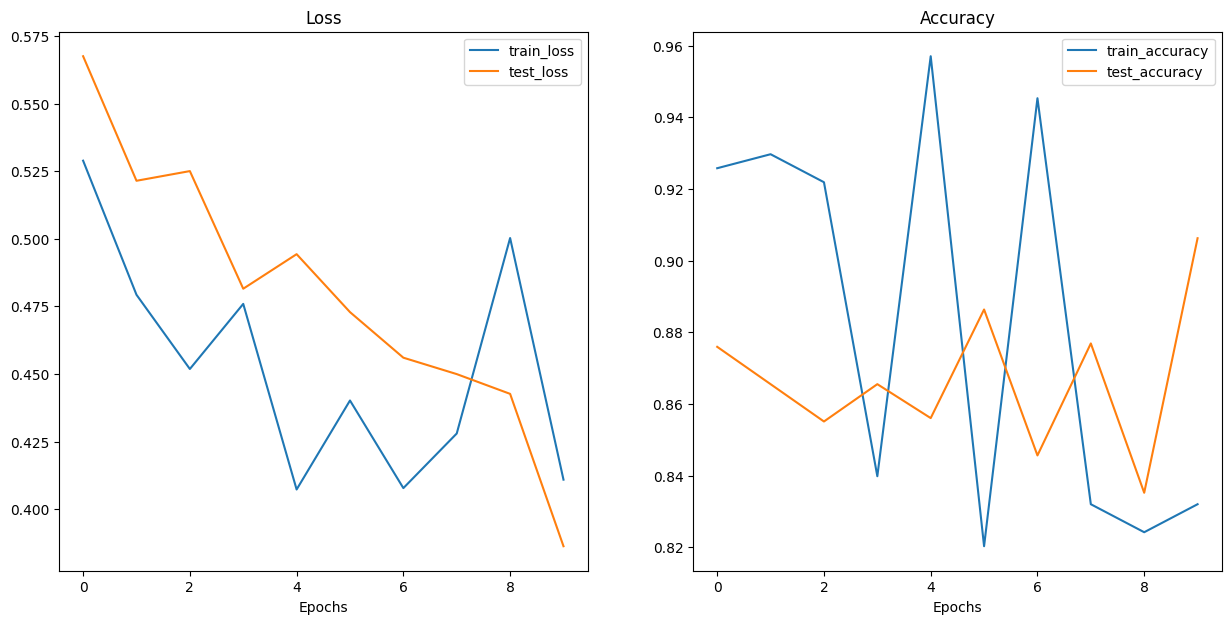

In [72]:
plot_loss_curves(results)

## 6. Make predicitons on images from test set

It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

*Visualize, visualize, visualize!*

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

This means we'll need to make sure our images have:

* Same shape - If our images are different shapes to what our model was trained on, we'll get shape errors.
* Same datatype - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.
* Same device - If our images are on a different device to our model, we'll get device errors.
* Same transformations - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

Steps:
1. Take in a trained model, a list of class names, a filepath to a target name, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly ralates to batch_size)
7. Make a prediciton on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.sofftmax()`
9. Convert model's prediciton probabilities to predicition labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the predicition label from step 9 and predicition probabilities from asddd


In [80]:
from typing import List, Tuple, Dict
from PIL import Image
from torchvision import transforms
# 1. Take in a trained model:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform:torchvision.transforms = None,
                        device : torch.device = device):
    # 2. Open the image with PIL
    img = Image.open(image_path)
    # 3. Create a transform if one doesn't exist
    if transform is not None:
        img_transform = transform
    else:
        img_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    ### Predict on image ###
    # 4 Make sure the model is on the target device
    model.to(device)
    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimmension
        transformed_image = img_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]
        # 7. Make a prediciton in the transformed image by passing it to the model also make sure it's on the target device
        target_image_pred = model(transformed_image.to(device))
        # 8. Convert the models output logits  to pred probs
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
        # 9. Covert the model's pred probs to pred labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
        # 10. Plot the image with predicited label and probability
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.2f}%")
        plt.axis(False);
#


['/content/PIZZA.jpg', '/content/suhsi.jpg', '/content/STEAK.jpg']


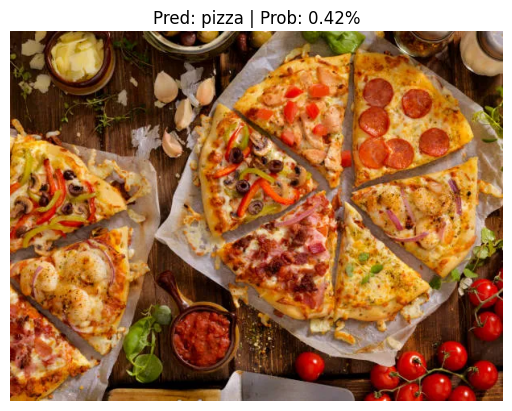

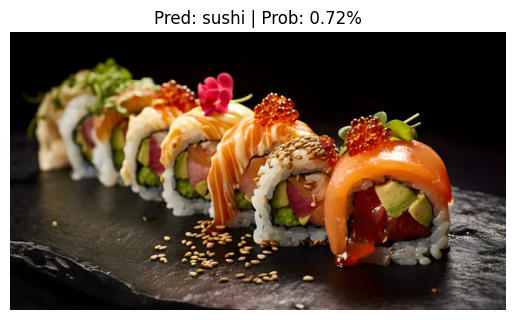

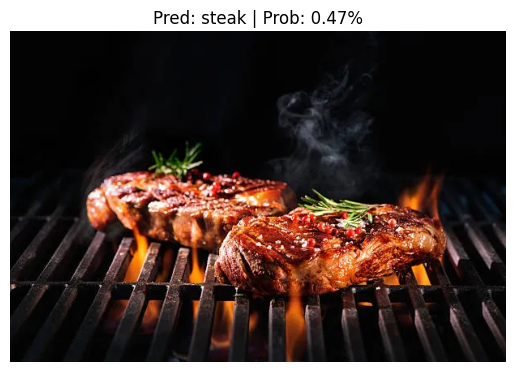

In [88]:
# Get random list of image paths from our  test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, num_images_to_plot)
image_samples = ["/content/PIZZA.jpg", "/content/suhsi.jpg", "/content/STEAK.jpg"]
print(image_samples)
# Make predicitions on and plot the images
for image_path in image_samples:
    pred_and_plot_image(model=model,
                    image_path=image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=auto_transforms,
                    device=device)